In [10]:
# OLD
# with open('bia030006.lab' , 'r') as f:
#     for line in f.readlines():
#         if("phones" in line[:10]):
#             print(line[10:].replace('|', '').split(), len(line[10:].replace('|', '').split()))

['#p', 'ac', 'ff', "'aa", 'zz', 'ic', 'll', "'oh", 'gg', 'uc', 'aa', 'pp', "'oh", 'zz', 'ac', 'pp', 'rd', 'oo', 'kk', 'll', 'aa', 'mm', 'aa', 'ss', "'an", 'wn', 'ff', 'ii', 'kk', "'oo", 'uw', 'kk', 'on', 'nh', 'ee', 'ss', "'ii", 'dd', 'ac', 'kk', "'oo", 'mm', 'uc', 'rx', 'ee', 'pp', "'uu", 'bb', 'll', 'ic', 'kk', 'ac', 'vv', "'eh", 'lh', 'ac', '#p'] 57


In [1]:
import librosa
import numpy as np
import pyworld as pw
import matplotlib.pyplot as plt
import pysptk

ln10_inv = 1 / np.log(10)


def pad_to(x, target_len):
    pad_len = target_len - len(x)

    if pad_len <= 0:
        return x[:target_len]
    else:
        return np.pad(x, (0, pad_len), 'constant', constant_values=(0, 0))


def eval_snr(x_r, x_s):
    # TODO: slide x_s to find max matched value 原論文有做滑動x_s，找到最大匹配的snr值，這邊還沒實作
    return 10 * np.log10(np.sum(x_s ** 2) / np.sum((x_s - x_r) ** 2))


def eval_MCD(x_r, x_s):
    # TODO: verify value 確認做出來的值是否正確 (和原論文比較)
    c_r = librosa.feature.mfcc(x_r)
    c_s = librosa.feature.mfcc(x_s)

    # plt.imshow(c_r)
    # plt.show()
    # plt.imshow(c_s)
    # plt.show()
    #
    # plt.plot(c_r[:, 20])
    # plt.plot(c_s[:, 40])
    # plt.show()
    # print((c_r- c_s))

    temp = 2 * np.sum((c_r - c_s) ** 2, axis=0)
    # print(temp)
    return 10 * ln10_inv * (temp ** 0.5)


def plot_f0(*files, title=None):
    for file in files:

        if isinstance(file, tuple):
            file_path, label = file
        else:
            file_path = file
            label = None

        aud, sr = librosa.load(file_path, sr=None)
        f0 = pysptk.sptk.swipe(aud.astype(np.double), sr, hopsize=128)
        plt.plot(f0, label=label)

    plt.ylabel('f0(Hz)')
    plt.xlabel('frame')
    if title:
        plt.title(title)
    plt.legend(loc='upper right')
    plt.show()


def eval_rmse_f0(x_r, x_s, sr, frame_len='5', method='swipe', tone_shift=None):
    # TODO: 要可以改動 frame len (ms) 或者 hop_size
    if method == 'harvest':
        f0_r, t = pw.harvest(x_r.astype(np.double), sr, frame_period=50)
        f0_s, t = pw.harvest(x_s.astype(np.double), sr, frame_period=50)
    elif method == 'dio':
        f0_r, t = pw.dio(x_r.astype(np.double), sr, frame_period=50)
        f0_s, t = pw.dio(x_s.astype(np.double), sr, frame_period=50)
    elif method == 'swipe':
        f0_r = pysptk.sptk.swipe(x_r.astype(np.double), sr, hopsize=128)
        f0_s = pysptk.sptk.swipe(x_s.astype(np.double), sr, hopsize=128)
    elif method == 'rapt':
        f0_r = pysptk.sptk.rapt(x_r.astype(np.double), sr, hopsize=128)
        f0_s = pysptk.sptk.rapt(x_s.astype(np.double), sr, hopsize=128)
    else:
        raise ValueError('no such f0 exract method')

    # length align
    f0_s = pad_to(f0_s, len(f0_r))

    # make unvoice / vooiced frame mask
    f0_r_uv = (f0_r == 0) * 1
    f0_r_v = 1 - f0_r_uv
    f0_s_uv = (f0_s == 0) * 1
    f0_s_v = 1 - f0_s_uv

    tp_mask = f0_r_v * f0_s_v
    tn_mask = f0_r_uv * f0_s_uv
    fp_mask = f0_r_uv * f0_s_v
    fn_mask = f0_r_v * f0_s_uv

    if tone_shift is not None:
        shift_scale = 2 ** (tone_shift / 12)
        f0_r = f0_r * shift_scale

    # only calculate f0 error for voiced frame
    y = 1200 * np.abs(np.log2(f0_r + f0_r_uv) - np.log2(f0_s + f0_s_uv))
    y = y * tp_mask
    # print(y.sum(), tp_mask.sum())
    f0_rmse_mean = y.sum() / tp_mask.sum()

    # only voiced/ unvoiced accuracy/precision
    vuv_precision = tp_mask.sum() / (tp_mask.sum() + fp_mask.sum())
    vuv_accuracy = (tp_mask.sum() + tn_mask.sum()) / len(y)

    return f0_rmse_mean, vuv_accuracy, vuv_precision

In [21]:
path_wav1 = "./data/VCTK/VCTK-Corpus/wav48/p226/p226_001.wav"
path_wav2 = "./data/VCTK/VCTK-Corpus/wav48/p226/p226_002.wav"

In [22]:
import sys
sys.path.insert(0, '')

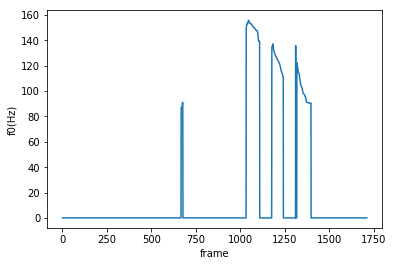

In [23]:
plot_f0(path_wav1)

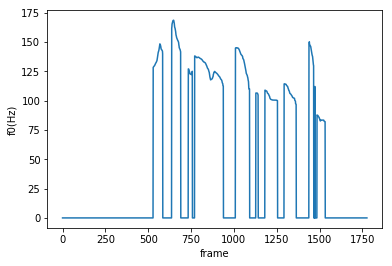

In [24]:
plot_f0(path_wav2)

In [25]:
aud_r, sr_r = librosa.load(path_wav1, sr=None)
aud_s, sr_s = librosa.load(path_wav2, sr=None)

In [26]:
assert sr_r == sr_s
if len(aud_r) != len(aud_s):
    aud_r = aud_r[:len(aud_s)]
    aud_s = aud_s[:len(aud_r)]

# mcd = eval_MCD(aud_r, aud_s)
rmse_f0 = eval_rmse_f0(aud_r, aud_s, sr_r)

In [27]:
rmse_f0

(276.8740084090907, 0.7081144191476941, 0.2838709677419355)

In [28]:
mcd = eval_MCD(aud_r, aud_s)
mcd.mean()

956.27673

In [29]:
rmse_f0 = eval_rmse_f0(aud_r, aud_r, sr_r)
rmse_f0

(0.0, 1.0, 1.0)

In [30]:
mcd = eval_MCD(aud_r, aud_r)
mcd.mean()

0.0

# Testing egemaps to CH corpus

In [34]:
import numpy as np
import pyworld as pw
import librosa
import os
import re
import matplotlib.pyplot as plt
import opensmile

In [35]:
import pandas as pd

ch_df = pd.read_csv("D:/Mestrado/CH Corpus/CH_Unicamp-20210309T013712Z-003/CH_Unicamp/base_recortes/recortes_silvano/correspondencias.csv", sep = ';',
                    names=["orig_name", "file_name", "style", "un1", "un2","un3", 'un4'])

emotions_corresp = pd.read_csv("D:/Mestrado/CH Corpus/CH_Unicamp-20210309T013712Z-003/CH_Unicamp/base_recortes/recortes_silvano/emotions.csv", sep = ';')

In [36]:
map_emotions = dict(emotions_corresp.values)
ch_df['style'] = ch_df['style'].map(map_emotions)
is_neutral = []
for orig_name in ch_df.orig_name:
    if re.search('Neutra', orig_name):
        is_neutral.append(1)
    else:
        is_neutral.append(0)
  
ch_df['is_neutral'] = is_neutral
ch_df.loc[ch_df['is_neutral'] == 1, 'style'] = 'Neutral'

In [47]:
local_path = "D:/Mestrado/CH Corpus/CH_Unicamp-20210309T013712Z-003/CH_Unicamp/base_recortes/recortes_silvano/audios/"

egemaps = pd.DataFrame()

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

emaps = smile.process_file(local_path + ch_df['file_name'].values[0] + '.wav')

egemaps = pd.concat([egemaps, emaps.reset_index()[emaps.columns.values[0:]]], axis = 1)

for wav in ch_df['file_name'].values[1:]:
    wav_path = local_path + wav + '.wav'
    emaps = smile.process_file(wav_path)
    egemaps = pd.concat([egemaps, emaps.reset_index()[emaps.columns.values[0:]]], axis = 0)

# ch_df['egemaps'] = egemaps

# ch_df

ValueError: cannot reindex from a duplicate axis

In [53]:
ch_df = pd.concat([ch_df, egemaps.reset_index()], axis = 1)
ch_df

,orig_name,file_name,style,un1,un2,un3,un4,is_neutral,index,F0semitoneFrom27.5Hz_sma3nz_amean,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,Em1_Fala1_CarolinaHolly_1,silvano0001,Happy-for,NaN,NaN,NaN,NaN,0,0,40.269268,...,0.079701,-0.007804,0.089389,2.546689,2.572899,0.228000,0.300670,0.173333,0.145736,-27.493999
1,Em1_Fala1_CarolinaHolly_2,silvano0002,Happy-for,NaN,NaN,NaN,NaN,0,0,39.176952,...,0.084138,-0.005029,0.128784,4.804805,1.834862,0.400000,0.161348,0.182500,0.230800,-28.552412
2,Em1_Fala1_CarolinaHolly_3,silvano0003,Happy-for,NaN,NaN,NaN,NaN,0,0,37.201374,...,0.077248,-0.008202,0.080505,3.015075,1.781171,0.388571,0.854324,0.150000,0.136905,-27.601904
3,Em1_Fala1_Neutra_CarolinaHolly_1,silvano0004,Neutral,NaN,NaN,NaN,NaN,1,0,34.974148,...,0.083451,-0.007684,0.142118,2.595156,2.807018,0.143125,0.136369,0.191875,0.168568,-30.585648
4,Em1_Fala1_Neutra_CarolinaHolly_2,silvano0005,Neutral,NaN,NaN,NaN,NaN,1,0,35.887791,...,0.091609,-0.006202,0.161759,4.179105,2.735562,0.248889,0.296739,0.096667,0.054365,-28.863190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,Em9_Fala3_CarolinaHolly_2,silvano0304,Admiration,NaN,NaN,NaN,NaN,0,0,36.615696,...,0.086088,-0.009202,0.142984,3.401361,2.469136,0.254444,0.327503,0.136471,0.136767,-28.742413
304,Em9_Fala3_CarolinaHolly_3,silvano0305,Admiration,NaN,NaN,NaN,NaN,0,0,33.760220,...,0.081699,-0.007201,0.105482,2.484472,2.034429,0.269231,0.375939,0.216667,0.278069,-30.282560
305,Em9_Fala3_Neutra_CarolinaHolly_1,silvano0306,Neutral,NaN,NaN,NaN,NaN,1,0,36.924099,...,0.080544,-0.008835,0.115301,2.777778,2.576113,0.225455,0.365274,0.154000,0.142982,-29.358248
306,Em9_Fala3_Neutra_CarolinaHolly_2,silvano0307,Neutral,NaN,NaN,NaN,NaN,1,0,36.226776,...,0.091714,-0.009813,0.186702,4.507513,2.702703,0.250625,0.203331,0.118462,0.109954,-28.438602


In [67]:
feats_cols

Index(['F0semitoneFrom27.5Hz_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
       'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean',
       'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0',
       'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0',
       'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope',
       'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope',
       'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean',
       'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean',
       'mfcc1_sma3_stddevNorm', 'mfcc2_

In [54]:
feats_cols = emaps.columns

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [60]:
ch_df['target'] = LabelEncoder().fit_transform(ch_df['style'])

In [71]:
cross_val_score(LogisticRegression(random_state = 42), ch_df[feats_cols], ch_df['target'], cv = 3, scoring= 'f1_micro')

C:\Users\lucas\Anaconda3\envs\m_audio\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\lucas\Anaconda3\envs\m_audio\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

array([0.45631068, 0.41747573, 0.51960784])

In [51]:
egemaps.shape

(308, 88)

In [52]:
egemaps

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,40.269268,0.241422,34.217781,44.907200,47.485771,13.267990,278.693298,249.547119,140.300201,104.219765,...,0.079701,-0.007804,0.089389,2.546689,2.572899,0.228000,0.300670,0.173333,0.145736,-27.493999
0,39.176952,0.109387,37.892300,40.234543,41.846359,3.954060,142.580978,240.374802,32.072998,9.222377,...,0.084138,-0.005029,0.128784,4.804805,1.834862,0.400000,0.161348,0.182500,0.230800,-28.552412
0,37.201374,0.183448,33.409538,37.981140,42.902618,9.493080,128.074142,151.475693,-63.409622,102.566063,...,0.077248,-0.008202,0.080505,3.015075,1.781171,0.388571,0.854324,0.150000,0.136905,-27.601904
0,34.974148,0.158505,32.136951,37.154922,39.206841,7.069889,1033.055786,868.031982,71.605820,55.598354,...,0.083451,-0.007684,0.142118,2.595156,2.807018,0.143125,0.136369,0.191875,0.168568,-30.585648
0,35.887791,0.122878,35.417389,37.230759,38.338070,2.920681,48.882149,44.296261,59.752304,76.269974,...,0.091609,-0.006202,0.161759,4.179105,2.735562,0.248889,0.296739,0.096667,0.054365,-28.863190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,36.615696,0.168125,35.349483,38.169182,40.263054,4.913570,54.640739,30.563606,66.340157,74.402374,...,0.086088,-0.009202,0.142984,3.401361,2.469136,0.254444,0.327503,0.136471,0.136767,-28.742413
0,33.760220,0.154382,31.335365,35.809856,36.606586,5.271221,110.243042,78.773911,24.891546,24.152071,...,0.081699,-0.007201,0.105482,2.484472,2.034429,0.269231,0.375939,0.216667,0.278069,-30.282560
0,36.924099,0.167398,34.448898,39.124306,40.828495,6.379597,122.702286,120.931114,95.572624,53.431126,...,0.080544,-0.008835,0.115301,2.777778,2.576113,0.225455,0.365274,0.154000,0.142982,-29.358248
0,36.226776,0.137353,34.443413,37.026875,39.315441,4.872028,52.541946,30.583359,99.497162,94.419342,...,0.091714,-0.009813,0.186702,4.507513,2.702703,0.250625,0.203331,0.118462,0.109954,-28.438602
